In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from patsy import bs, dmatrix
import statsmodels.api as sm
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.signal import find_peaks, find_peaks_cwt, argrelmax, argrelmin, argrelextrema
# from scipy.interpolate import BSpline

In [2]:
np.random.seed(42)
h = lambda x: (1/pi)*np.arcsin(x**(1/3)) + (1/pi)*np.arcsin(x**(1/6))
f = lambda x: x*np.sin(20*x)
x = np.linspace(0,1,1000)
y = f(h(x)) + np.random.randn(1000)*0.3

In [3]:
def find_least_sumsquareerror_under_knots1(theta):
        knots = np.arange(1, 2**1) / 2**1        
        ans = bx1 @ theta.reshape((-1, 1))
        ans = ans.flatten()
        return np.sum((y - f(ans))**2)

bx1 = bs(x=x, knots=np.arange(1, 2**1) / 2**1, lower_bound=0,
        upper_bound=1, include_intercept=True,
        degree=3)

mod1 = sm.OLS(h(x), bx1)
res1 = mod1.fit()

opt1 = minimize(find_least_sumsquareerror_under_knots1, res1.params,
                method='Nelder-Mead', options={'maxiter':50})

hhat1 = bx1 @ res1.params.reshape((-1, 1))
hhat1 = hhat1.flatten()

In [4]:
def find_least_sumsquareerror_under_fixed_knots(theta):
        knots = np.arange(1, 2**i) / 2**i        
        ans = bxi @ theta.reshape((-1, 1))
        ans = ans.flatten()
        return np.sum((y - f(ans))**2)

def hhat_func(x):
    h_hat = bs(x=x, knots=np.arange(1, 2**i) / 2**i, lower_bound=0,
               upper_bound=1, include_intercept=True, degree=3) @ opt.x
    h_hat = h_hat.flatten()
    return h_hat

def ISE(x):
    return (h(x) - hhat_func(x))**2

In [5]:
opti_value_list = []
opti_array_list = []
ISE_list = []
bx_list = []
for i in range(1, 9):
    bxi = bs(x=x, knots=np.arange(1, 2**i) / 2**i, lower_bound=0,
                 upper_bound=1, include_intercept=True, degree=3)

    if i == 1:
        modi = sm.OLS(hhat1, bxi)
        resi = modi.fit()
        opt = minimize(find_least_sumsquareerror_under_fixed_knots, resi.params,
                       method='Nelder-Mead', options={'maxiter':100})
    else:
        
        hhati = bx_list[-1] @ opti_array_list[-1].reshape((-1, 1))
        modi = sm.OLS(hhati, bxi)
        resi = modi.fit()
        opt = minimize(find_least_sumsquareerror_under_fixed_knots, resi.params,
                       method='Nelder-Mead', options={'maxiter':100})


    integral_value, _ = quad(ISE, 0, 1)
    # print(f"\noptimal value {i}:", opt.fun, f"\noptimal vector {i}:", opt.x)
    ISE_list.append(integral_value)
    opti_value_list.append(opt.fun)
    opti_array_list.append(opt.x)
    bx_list.append(bxi)

ipykernel_launcher:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


In [6]:
print(opti_value_list)
print(ISE_list)

[89.90540252623029, 87.11941044648658, 85.74872707436296, 85.50618286058031, 84.56689302732806, 83.61977267022698, 83.07895082295299, 82.4983889005708]
[0.0001249110023457206, 5.9811472581206976e-05, 3.690615927749374e-05, 4.127423470014637e-05, 4.1689128727287226e-05, 6.735769540221892e-05, 7.717648506194613e-05, 8.342040082751668e-05]


In [7]:
print("least SSE:", min(opti_value_list))
print("least SSE Index:", opti_value_list.index(min(opti_value_list)))
print("least ISE:", min(ISE_list))
print("least ISE index:", ISE_list.index(min(ISE_list)))

least SSE: 82.4983889005708
least SSE Index: 7
least ISE: 3.690615927749374e-05
least ISE index: 2


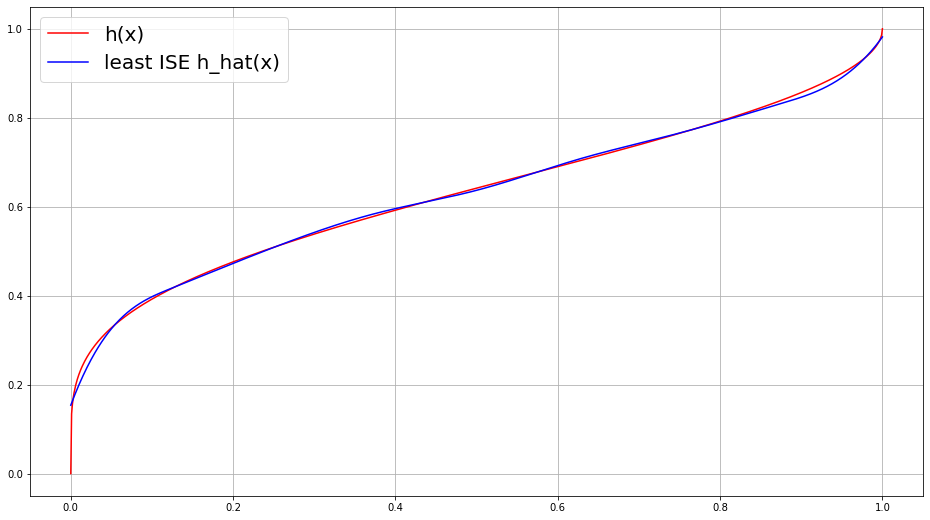

In [8]:
bx8 = bs(x=x, knots=np.arange(1, 2**8) / 2**8, lower_bound=0,
         upper_bound=1, include_intercept=True, degree=3)
hhat8 = bx8 @ opti_array_list[7].reshape((-1, 1))

bx3 = bs(x=x, knots=np.arange(1, 2**3) / 2**3, lower_bound=0,
         upper_bound=1, include_intercept=True, degree=3)
hhat3 = bx3 @ opti_array_list[2].reshape((-1, 1))

plt.figure(figsize=(16, 9))
line_h, = plt.plot(x, h(x), "r-", label="h(x)")
line_hhat, = plt.plot(x, hhat3, "b-", label="least ISE h_hat(x)")
plt.legend(handles=[line_h, line_hhat], loc="best", fontsize=20)
plt.grid()
plt.show()

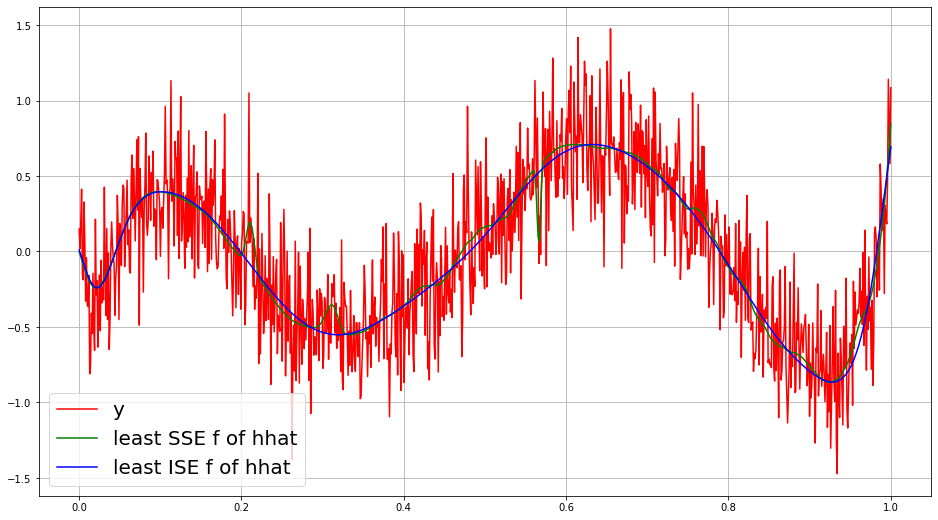

In [9]:
plt.figure(figsize=(16, 9))
original_fh, = plt.plot(x, y, "r-", label="y")
least_sse_fhhat, = plt.plot(x, f(hhat8),
                            "g-", label="least SSE f of hhat")
least_ISE_fhhat, = plt.plot(x, f(hhat3), "b-", label="least ISE f of hhat")
plt.legend(handles=[original_fh, least_sse_fhhat, least_ISE_fhhat], loc="best", fontsize=20)
plt.grid()
plt.show()

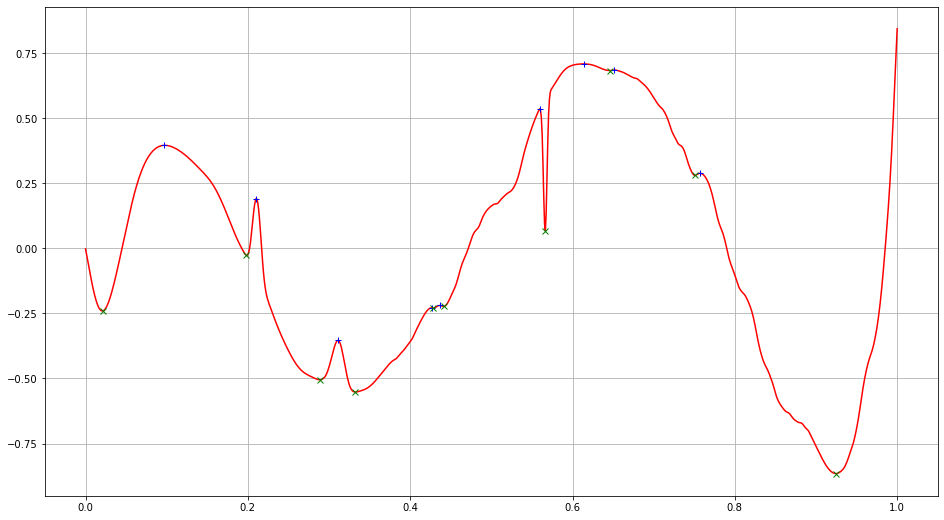

In [10]:
SSE_valleys = argrelmin(f(hhat8))
SSE_peaks = argrelmax(f(hhat8))

plt.figure(figsize=(16, 9))
plt.plot(x, f(hhat8), "r-")
plt.plot(x[SSE_peaks[0]], f(hhat8)[SSE_peaks[0]], "b+")
plt.plot(x[SSE_valleys[0]], f(hhat8)[SSE_valleys[0]], "gx")
plt.grid()
plt.show()

num of valleys: 339
num of peaks: 338


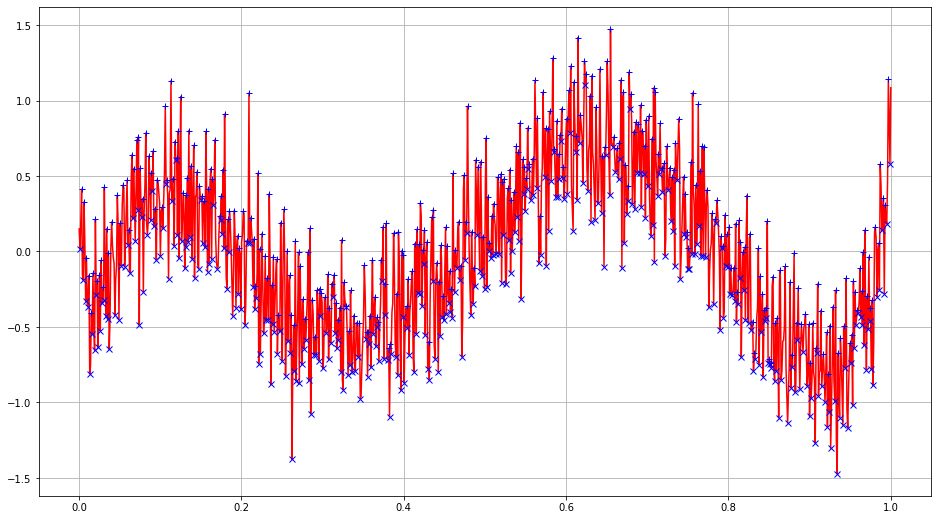

In [11]:
valleys = argrelmin(y)
peaks = argrelmax(y)
print("num of valleys:", valleys[0].shape[0])
print("num of peaks:", peaks[0].shape[0])

plt.figure(figsize=(16, 9))
plt.plot(x, y, "r-")
plt.plot(x[peaks[0]], y[peaks[0]], "b+")
plt.plot(x[valleys[0]], y[valleys[0]], "bx")
plt.grid()
plt.show()

2000it [00:00, 52877.93it/s][findpeaks] >Finding peaks in 1d-vector using [topology] method..
[findpeaks] >Detect peaks using topology method with limit at None.

C:\Users\tiger\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


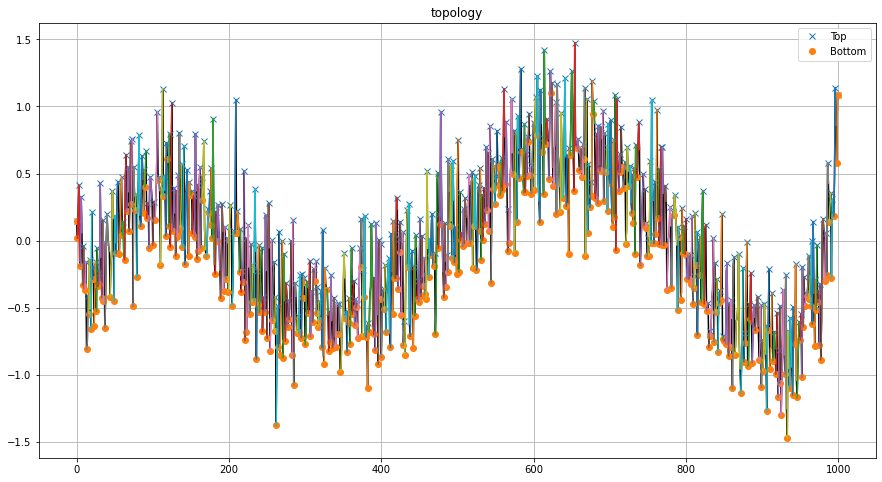

(None, <AxesSubplot:title={'center':'topology'}>)

In [12]:
from findpeaks import findpeaks
fp = findpeaks(method="topology")
fp.fit(y)
fp.plot()

In [13]:
print(fp.results["df"]["peak"].sum())
print(fp.results["df"]["valley"].sum())

340
341
